# Consistency among reviews and ratings for products

## Introduction

The popularity of a product can to some extent be reflected by customer reviews and corresponding ratings. Intuitively we may assume that a positive review is always related to a high rating. A customer review may either consist of a few words or it can be a long paragraph. The online shopping website, like Amazon, receives thousands of customer reviews on different kinds of products every day. It takes a large amount of time if we want to inspect each review carefully and it is hard to define positive or negative objectively. Therefore, a multiclass classification model would be helpful when large amount of new reviews come in. It helps to quickly classify the reviews into the rating class and result can be easily telled from the label prediction instead of spending time reading each review. The project intends to build a multiclass classifier based on SVM  to predict the rating class of reviews based on `Amazon product dataset`. It also gives some insight on the confidence of probability distribution of a new prediction and several potential ways to improve the performance metrics on imbalanced dataset (ie: the positive reviews can be more than negative reviews, generally).

## Installation
Before getting started, you'll need to install various packages that will be used in this project. It is strongly recommanded to use Anaconda since all the open source packages can be individually installed from the Anaconda repository. By calling

$ pip install [packages you want to install]

Or

$ conda install [packages you want to install]

Anaconda compiles and builds all the packages in the Anaconda repository itself. The packages required are listed as follow.

You can also refer to requirements.txt to figure out the required packages.

## Data Collection

The product data we use is collected by Datafiniti Product API  
https://developer.datafiniti.co/docs/product-data-with-python-csv  

By assigning the query string as `{ "query": "dateUpdated:[2017-09-01 TO *] AND brand:Amazon* AND categories:* AND primaryCategories:* AND name:* AND reviews:*", "format": "csv", "download": true }`

We can use the following script provided by the Datafiniti website to extract `Amazon product` information and related customer reviews. The downloaded data is further processed using Excel function to constraint to the category `Amazon electronics product` with around 23000 datapoints.




In [57]:
# Illustrates an API call to Datafiniti's Product Database.
# Provided by Datafiniti
import requests
import urllib.parse
import json
import time

def get_data():
    # Set your API parameters here.
    API_token = 'AAAXXXXXXXX'
    view_name = 'product_flat_prices'
    format = 'CSV'
    query = 'categories:shoes AND -categories:shirts AND categories:women AND (brand:* OR manufacturer:*) AND prices:*'
    num_records = 50
    download = True

    request_headers = {
        'Authorization': 'Bearer ' + API_token,
        'Content-Type': 'application/json',
    }
    request_data = {
        'query': query,
        'view': view_name,
        'format': format,
        'num_records': num_records,
        'download': download
    }

    # Make the API call.
    r = requests.post('https://api.datafiniti.co/v4/products/search',json=request_data,headers=request_headers);

    # Do something with the response.
    if r.status_code == 202:
        request_response = r.json()
        print(request_response)

        # Keep checking the request status until the download has completed
        download_id = request_response['id']
        download_status = request_response['status']

        while (download_status != 'completed'):
            time.sleep(5)
            download_r = requests.get('https://api.datafiniti.co/v4/downloads/' + str(download_id),headers=request_headers);
            download_response = download_r.json()
            download_status = download_response['status']
            print('Records downloaded: ' + str(download_response['num_downloaded']))

        # Once the download has completed, get the list of links to the result files and download each file
        if download_status == 'completed':
            result_list = download_response['results']
            i = 1;
            for result in result_list:
                filename = str(download_id) + '_' + str(i) + '.' + format
                urllib.request.urlretrieve(result,filename)
                print('File: ' + str(i) + ' out of ' + str(len(result_list)) + ' saved: ' + filename)
                i += 1

    else:
        print('Request failed')
        print(r)

## Data Visualization

In [58]:
import pandas as pd
import numpy as np
import seaborn as sn
import nltk
import re
import string
import matplotlib.pyplot as plt
import sklearn
from wordcloud import WordCloud
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from imblearn.over_sampling import SMOTE

We first download the `nltk` package for later reviews text processing. The code is modified from practical data science homework assignment starter codes.

In [59]:
def nltk_download_test(nltk_download):
    nltk_download()
    try:
        lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
        stopwords=nltk.corpus.stopwords.words('english')
    except LookupError:
        None

def nltk_download():
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt')
    
lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
stopwords=nltk.corpus.stopwords.words('english')

In [60]:
df = pd.read_csv("amazon.csv")
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


The only fields that we need are the review text and their corresponding ratings. Therefore we can further visualize the dataset into two columns

In [61]:
df[["reviews.rating","reviews.text"]].head()

,reviews.rating,reviews.text
0,3,I order 3 of them and one of the item is bad q...
1,4,Bulk is always the less expensive way to go fo...
2,5,Well they are not Duracell but for the price i...
3,5,Seem to work as well as name brand batteries a...
4,5,These batteries are very long lasting the pric...


Since it is a relative big dataset, it would be helpful to get all the class label in advance instead of inspecting line by line.

In [62]:
labels = df["reviews.rating"]
labels.unique()

array([3, 4, 5, 1, 2], dtype=int64)

The wordcloud below provides us a direct view on word frequency distribution in the dataset.

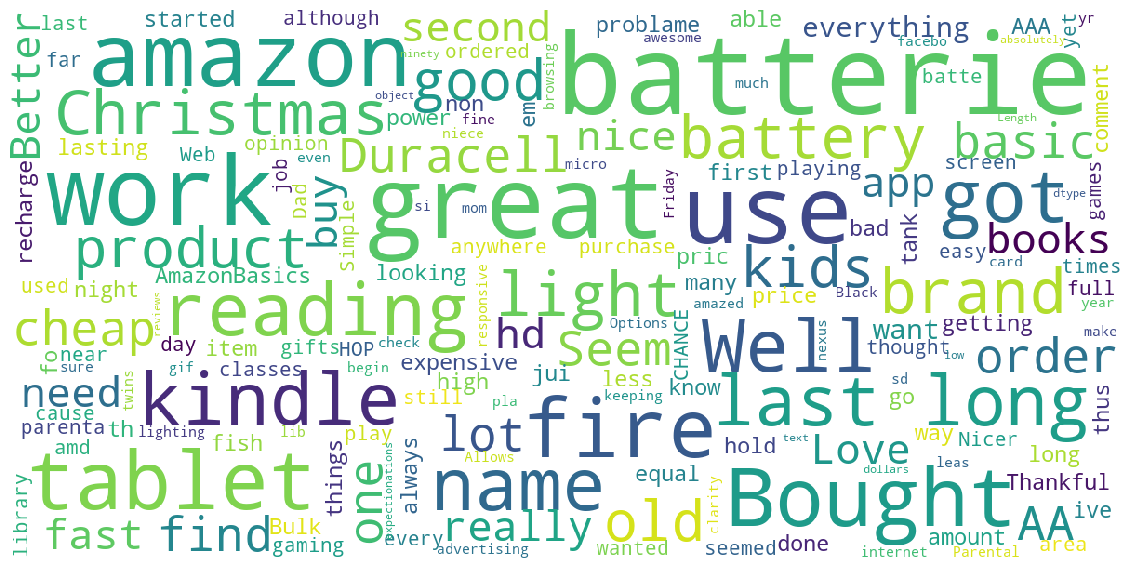

In [63]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df["reviews.text"])

Since this is a multiclass classification problem, it's worthwhile inspecting the distribution of reviews to know which rating class they belong to.

<Figure size 720x432 with 0 Axes>

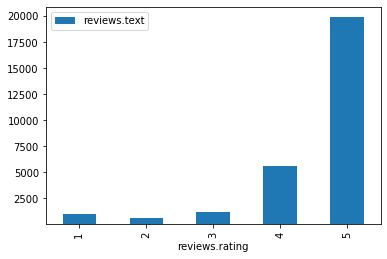

In [64]:
fig = plt.figure(figsize=(10,6))
df = df[["reviews.rating","reviews.text"]]
df.groupby("reviews.rating").count().plot.bar(ylim=1)
plt.show()

Our dataset is unbalanced (it has more samples for some classes than others). This can make the classifier biased toward the one or two classes with lost of samples, while dwarfing others that have less (i.e. the classifier learns the classes with more samples better and remains weak on the smaller classes). It might leads to a problem that when a new negative review comes in, it will be mistakenly classified into the high rating class. This suggests we may want to resample the train dataset to ensure that our classifier is trained equally by samples in each class. But right now, we just follow the normal process to see how accurate our classifier can be. 

## Data Processing and Analysis

The dataset is pre-processed by removing invalid rows and constructing a`bag-of-word model` using `tfidf` matrix. The code is modified from the homework assignment. Then the analysis is performed by building a `multiclass SVM classifier` using `scikit-learn`. The steps can be generalized as follow: 

1. Analyze the `performance` of classifier using orginal dataset without any preprocessing (raw data from csv)
2. Analyze the `performance` of classifier using pre-processed dataset
3. Propose potential solutions on imbalance dataset handling

By `performance`, we mean the performance matrics regarding `accuracy`, `recall` and `F1 score`.

In [65]:
# Remove null input
df = df[pd.notnull(df["reviews.text"])]

In [66]:
def preprocess(text, stopwords={}, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    # handle URL
    text = re.sub(r'(http|https)://t.co/[a-zA-Z0-9]{10}', ' ', text)
    
    # remove trailing "'s"
    text = text.replace("'s", "")

    # remove trailing "'S"
    text = text.replace("'S", "")
    
    # omit other apostrophes
    text = text.replace("'", "")
    
    # replace with whitespace
    for c in text:
        if c in string.ascii_letters or c in string.digits:
            continue
        else:
            text = text.replace(c, " ")
    
    # to lower case
    text = text.lower()
    
    # tokenize with whitespace
    text = nltk.word_tokenize(text)
    
    # lemmatize each word in the text list
    text = [lemmatizer.lemmatize(w) for w in text]
    
    # remove the word in the stoplist
    # stopwords = set(nltk.corpus.stopwords.words('english'))
    text = [w for w in text if w not in stopwords]
    
    return " ".join(text)

In [67]:
# This is an analyzer allowing different customizable parameters
def analyze(text, labels, clean=False, cfm=False, resample=False):
    
    # Split the test and train dataset
    X_train, X_test, y_train, y_test = train_test_split(text, labels, random_state=0, test_size=0.2)
        
    #  Build the word count matrix
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_train)
    X_test_counts = count_vect.transform(X_test)
    
    # Transform the word count matrix into tfidf matrix
    tf_transformer = TfidfTransformer().fit(X_train_counts)
    X_train_transformed = tf_transformer.transform(X_train_counts)
    X_test_transformed = tf_transformer.transform(X_test_counts)
    
    # Encode the rating label
    labels = LabelEncoder()
    y_train_labels_fit = labels.fit(y_train)
    y_train_labels_trf = labels.transform(y_train)
    
    # Over-sample the dataset to account for imbalance
    if resample:
        sm = SMOTE()
        X_train_transformed, y_train_labels_trf = sm.fit_resample(X_train_transformed, y_train_labels_trf)
        
        # Just used to plot the count of samples of each class
        print("class distribution after resampling")
        y = pd.Series(y_train_labels_trf, name="y")
        count = pd.Series([0]*len(y))
        df = pd.concat([y,count],axis=1)
        fig = plt.figure(figsize=(10,6))
        df.groupby("y").count().plot.bar(ylim=1)
        plt.show()
        
    #  Fit the multiclass SVM model
    linear_svc = LinearSVC()
    clf = linear_svc.fit(X_train_transformed,y_train_labels_trf)
    
    # Fit the multiclass SVM model with ability to reveal probability
    calibrated_svc = CalibratedClassifierCV(base_estimator=linear_svc, cv="prefit")

    calibrated_svc.fit(X_train_transformed,y_train_labels_trf)
    predicted = calibrated_svc.predict(X_test_transformed)
    
    # Demo input review for testing
    to_predict = "I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work."
    
    # Whether we want the test review to be pre-processed
    if clean == False:
        to_predict = [to_predict]
    else:
        to_predict = [preprocess(to_predict, stopwords)]

    p_count = count_vect.transform(to_predict)
    p_tfidf = tf_transformer.transform(p_count)
    
    # Whether we want to show confusion matrix or the following output
    if not cfm:
        print('Accuracy on test set={}'.format(np.mean(predicted == labels.transform(y_test))))
        # Don't average by weight, since we want to spot impact of unbalanced dataset
        print('Recall on test set={}'.format(recall_score(labels.transform(y_test), predicted, average='macro',)))
        
        # Don't average by weight, since we want to spot impact of unbalanced dataset
        print('F1 score on test set={}'.format(f1_score(labels.transform(y_test), predicted, average='macro',)))
        
        print('Predicted probabilities of demo input string are')
        display(pd.DataFrame(calibrated_svc.predict_proba(p_tfidf)*100, columns=labels.classes_))
        
    return predicted, labels.transform(y_test)

# Call the analyzer without review pre-processing
text = df["reviews.text"]
labels = df["reviews.rating"]
call = analyze(text, labels)


Accuracy on test set=0.7884242103405682
Recall on test set=0.577591469772075
F1 score on test set=0.6154270298078303
Predicted probabilities of demo input string are


,1,2,3,4,5
0,6.633822,0.033572,47.266678,41.065022,5.000906


In [68]:
# Call the analyzer with review pre-processing
process=lambda t: preprocess(t, stopwords)
stopwords = set(nltk.corpus.stopwords.words('english')) | set(["http", "co", "rt", "amp"])
text = pd.Series(list(map(process, text)))
call = analyze(text, labels, clean=True)

Accuracy on test set=0.7794247397211929
Recall on test set=0.5538736927902198
F1 score on test set=0.5940333447312277
Predicted probabilities of demo input string are


,1,2,3,4,5
0,22.556014,0.025739,54.731638,16.183246,6.503363


The accuracy scores remain roughly the same, with a slightly decrease after the reviews are preprocessed. However, in terms of the predicted probability distribution of an input review, though both trained models can predict the class correctly (the demo review actually belongs to `rating group 3`), using the processed reviews as input for training can increase the confidence of our prediction, which has a more centralized probability distribution.

## Confusion matrix

As we mentioned above, the dataset we are using is imbalanced. With imbalanced classes, it's easy to get a high accuracy without actually making useful predictions. So, accuracy as an evaluation metrics makes sense only if the class labels are uniformly distributed. In case of imbalanced classes confusion-matrix is good technique to summarizing the performance of a classification algorithm. Confusion Matrix is a performance measurement for a classification algorithm where output can be two or more classes.

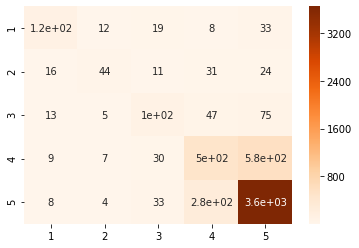

In [69]:
predicted, y_test = analyze(text, labels, clean=True, cfm=True)
columns = [1,2,3,4,5]
confm = confusion_matrix(y_test, predicted)
df_cm = pd.DataFrame(confm, index=columns, columns=columns)

ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)

We can tell from the above confusion matrix that class 4 and 5 which have more samples than others do have a high score `(class 4: 530, class 5: 3600)`, compared with those classes who have less samples `(class 1, 2, 3)`. Thus looking at the confusion matrix can clearly see how the model is performing on classifying various classes.

## Imbalanced handling

There are many techniques that can help us improve the performance of imbalanced dataset. One of the most popular strategies is to resample our dataset. Depend on the size, two ways are available to make the dataset balance.

1. Under-sampling: Remove samples from over-represented classes when we have huge dataset
2. Over-sampling: Add more samples from under-represented classes when we have small dataset

Here we will focus on the over-sampling technique, since our dataset is not big enough to leave out datapoints based on the minority class. We will use a over-sampling technique called `SMOTE (Synthetic Minority Over-sampling Technique)`. `SMOTE` uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model. It augments the dataset with artificial data and can be accessed by `imblearn` python package.

class distribution after resampling


<Figure size 720x432 with 0 Axes>

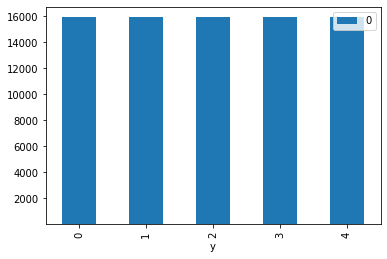

Accuracy on test set=0.6751367566613728
Recall on test set=0.6031622730176321
F1 score on test set=0.5317746003775607
Predicted probabilities of demo input string are


,1,2,3,4,5
0,1.799845,0.000218,96.452218,1.085955,0.661764


In [70]:
result = analyze(text, labels, clean=True, cfm=False, resample=True)

Compared with the previous skewed datapoints class distribution, we now have a dataset with equal sample size in each class. However, the accuracy decreases while the recall score increases. The F1 score and predicted probability confidence on the demo input vary by each separate call. The instability in prediction may result from the fact that it is hard to over sample `text` data, and the extra generated datapoints may not be validated. But again, we can look at the confusion matrix to evaluate the performance of classification algorithm. 

class distribution after resampling


<Figure size 720x432 with 0 Axes>

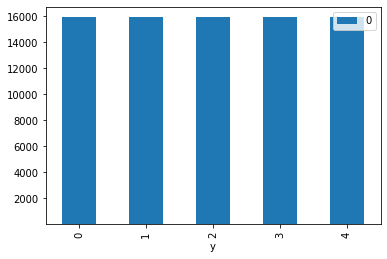

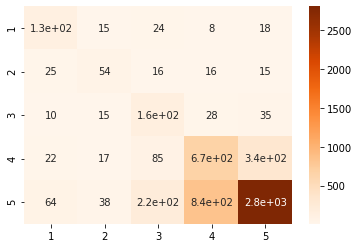

In [71]:
predicted, y_test = analyze(text, labels, clean=True, cfm=True, resample=True)
columns = [1,2,3,4,5]
confm = confusion_matrix(y_test, predicted)
df_cm = pd.DataFrame(confm, index=columns, columns=columns)

ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)

There is a minor increase in the confusion score in class 1, 2 and 3. We can generalize the difference as follows:

1. class 1: 120 to 130
2. class 2: 44 to 54
3. class 3: 100 to 160

The increase in confusion score is not significant therefore over-sampling the dataset may not be a good option. We may want to switch to a different algorithm instead of focusing on performance metrics, espeacially when we are dealing with imbalanced dataset.

## Conclusion
As we can see above, the customer reviews are generally nested in several different rating classes which leads to a multiclass classification problem. The distribution of class can be highly skewed especially when the reviews polarize and result in an imbalanced dataset. Since it's a text-based dataset, it raises more challenge when trying to resample the dataset to deal with the imbalanced property. The SMOTE technique we use in the analysis is based on kNN algorithm to generate additional datapoints to balance the dataset. There is only a slightly increase in the confusion score and resampling process suffers from a certain level of uncertainty, which means that the generated datapoints may not be that "effective" in reducing the imbalance among classes (ie: it still repeat the datapoints in those classes with high frequency)  

In addition to the technique in dealing with imbalanced dataset. The preprocessing of reviews is proved to be helpful in increasing the accuracy of classifying, especially in the probability distribution of each review. We are more confident when the probability distribution function centralizes and it could lead to a better result. However, the overall accuracy and F1 score do not change significantly before and after preprocessing. The problem might be some of the review probability distribution functions are not optimized or they have several peaks. 



## Future work
One of the rule of thumbs in machine learning problem is to try several algorithms to see which one fits well to our dataset, especially when dealing imbalanced data. Due to the time limit, I haven't got a chance to try a another algorithm on the dataset. But the plan is to try random forest classifier first since it is mentioned in several articles regarding imbalanced data. Since the improvement in preprocessing is not significant, I am considering to take a step in understanding the ground truth of positive and negative property of customer review, I am planning to spend sometime in NLTK Vadar module doing sentiment analysis on the reviews.

## References

1. Seaborn: https://seaborn.pydata.org/: https://www.scipy.org/
2. Numpy: https://numpy.org/
3. Pandas: https://pandas.pydata.org/
4. NLTK: https://www.nltk.org/
5. Matplotlib: https://matplotlib.org/
6. Scikit-learn: https://scikit-learn.org/stable/
7. PDS website: http://www.datasciencecourse.org/information/
8. Dealing with imbalance data: https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
9. Datafiniti website: https://developer.datafiniti.co/docs/product-data-with-python-csv
10. Tips and Tricks for Multi-Class Classification: https://medium.com/@b.terryjack/tips-and-tricks-for-multi-class-classification-c184ae1c8ffc

The data collection script is modified from Datafiniti website  
The preprocessing script is modified from PDS hw3 text assignment  
The word cloud function is modified from https://towardsdatascience.com/detecting-bad-customer-reviews-with-nlp-d8b36134dc7e